# Feature Selection



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel
from bartpy.featureselection import SelectNullDistributionThreshold, SelectSplitProportionThreshold
from bartpy.diagnostics.features import *

%matplotlib inline

Text(0.5,1,'X v y')

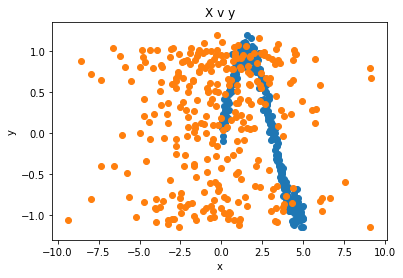

In [2]:
x = np.linspace(0, 5, 300)
X = np.random.normal(0, 3, size = 300 * 2).reshape(300, 2)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=300) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

# Sklearn API

Feature selection can be done in BartPy using the Sklearn selector API.  This allows for deep integration with the Sklearn pipelines

### Proportion Threshold

The simplest way to select features is to set a threshold on how often a variable is used in splits in the model trees.  The more times a tree appears in the model, the more likely it is that the feature is important and captures a meaningful pattern.

While this method is simple, the downside is that it is hard to set the threshold appropriately.  Cross validation is recommended

In [15]:
from copy import deepcopy

from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_selection.base import SelectorMixin
from sklearn.base import BaseEstimator

from bartpy.diagnostics.features import null_feature_split_proportions_distribution, \
    local_thresholds, global_thresholds, is_kept, feature_split_proportions_counter, plot_feature_proportions_against_thresholds, plot_null_feature_importance_distributions, \
    plot_feature_split_proportions
from bartpy.sklearnmodel import SklearnModel


class SelectSplitProportionThreshold(BaseEstimator, SelectorMixin):

    def __init__(self,
                 model: SklearnModel,
                 percentile: float=0.2):
        self.model = deepcopy(model)
        self.percentile = percentile

    def fit(self, X, y):
        self.model.fit(X, y)
        self.X, self.y = X, y
        self.feature_proportions = feature_split_proportions_counter(self.model.model_samples)
        return self

    def _get_support_mask(self):
        return np.array([proportion > self.percentile for proportion in self.feature_proportions.values()])


    def plot(self):
        plot_feature_split_proportions(self.model.model_samples)


class SelectNullDistributionThreshold(BaseEstimator, SelectorMixin):

    def __init__(self,
                 model: SklearnModel,
                 percentile: float=0.95,
                 method="local",
                 n_permutations=10):
        if method == "local":
            self.method = local_thresholds
        elif method == "global":
            self.method = global_thresholds
        else:
            raise NotImplementedError("Currently only local and global methods are supported, found {}".format(self.method))
        self.model = deepcopy(model)
        self.percentile = percentile
        self.n_permutations = n_permutations

    def fit(self, X, y):
        self.model.fit(X, y)
        self.X, self.y = X, y
        self.null_distribution = null_feature_split_proportions_distribution(self.model, X, y, self.n_permutations)
        self.thresholds = local_thresholds(self.null_distribution, self.percentile)
        self.feature_proportions = feature_split_proportions_counter(self.model.model_samples)
        return self

    def _get_support_mask(self):
        return np.array(is_kept(self.feature_proportions, self.thresholds))

    def plot(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        plot_feature_proportions_against_thresholds(self.feature_proportions, self.thresholds, ax1)
        plot_null_feature_importance_distributions(self.null_distribution, ax2)


In [16]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=20, store_in_sample_predictions=False)
pipeline = make_pipeline(SelectSplitProportionThreshold(model, 0.3), model)
pipeline_model = pipeline.fit(X, y)

In [17]:
print("Feature Proportions", pipeline_model.named_steps["selectsplitproportionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectsplitproportionthreshold"]._get_support_mask())

Feature Proportions {0: 0.5144900263455024, 1: 0.1844185171245766}
Is Kept [ True False]


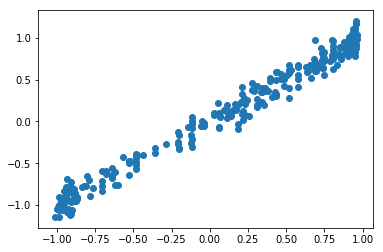

In [18]:
plt.scatter(model.predict(X), y)

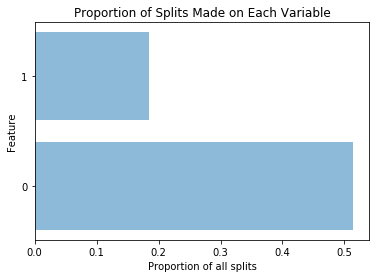

In [19]:
pipeline_model.named_steps["selectsplitproportionthreshold"].plot()

### Null Distribution Threshold

For a more principled analysis, BartPy implements the method described in https://repository.upenn.edu/cgi/viewcontent.cgi?article=1555&context=statistics_papers.

This is significantly more computationally expensive, but offers a principled way to set proportions

In [3]:
model = SklearnModel(n_samples=500, n_burn=200, n_trees=20, store_in_sample_predictions=False, n_jobs=-1)
pipeline = make_pipeline(SelectNullDistributionThreshold(model, 0.9, "local"), model)
pipeline_model = pipeline.fit(X, y)

In [4]:
print("Thresholds", pipeline_model.named_steps["selectnulldistributionthreshold"].thresholds)
print("Feature Proportions", pipeline_model.named_steps["selectnulldistributionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectnulldistributionthreshold"]._get_support_mask())

Thresholds {0: 0.36518796356145156, 1: 0.3581688213582532}
Feature Proportions {0: 0.5162470725995316, 1: 0.1910128805620609}
Is Kept [ True False]


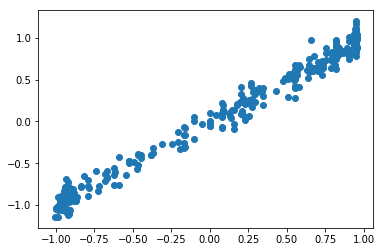

In [5]:
plt.scatter(model.predict(X), y)

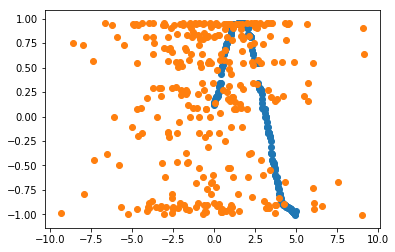

In [6]:
plt.scatter(X[:,0], model.predict(X))
plt.scatter(X[:,1], model.predict(X))

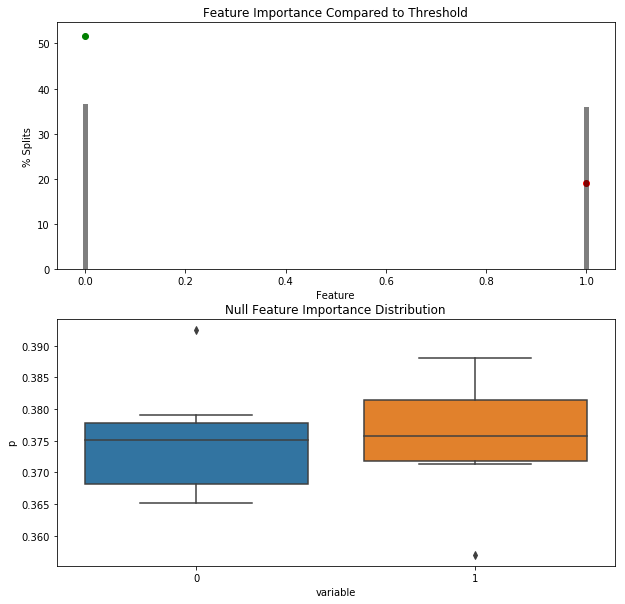

In [7]:
pipeline_model.named_steps["selectnulldistributionthreshold"].plot()

## Lower level API

If you want functionality not offered in the Sklearn API, or want to understand the internals, we can drop down into the BartPy API

## Create a benchmark null distribution

To identify whether features are important, we need a baseline "null" distribution to compare the inclusion proportions to.  To do this, we create a set of data where the target variable is randomly permuted to remove any relationship between the covariates and the target

In [4]:
null_distributions = null_feature_split_proportions_distribution(model, X, y, n_permutations=3)

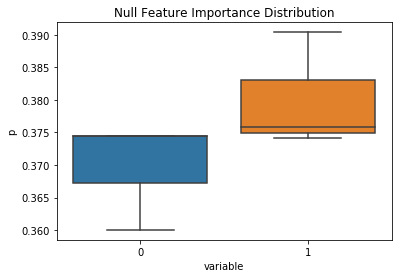

In [5]:
plot_null_feature_importance_distributions(null_distributions)

In [6]:
thresholds = local_thresholds(null_distributions, 0.95) 

## Fit BartPy to the true data

In [7]:
model.fit(X, y)

SklearnModel(alpha=0.95, beta=2.0, n_burn=50, n_chains=4, n_jobs=4,
       n_samples=1000, n_trees=50, p_grow=0.5, p_prune=0.5, sigma_a=0.001,
       sigma_b=0.001, store_in_sample_predictions=False, thin=0.1)

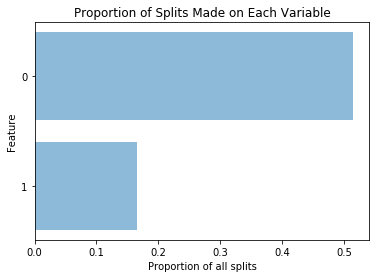

In [8]:
proportions = feature_split_proportions_counter(model.model_samples)
plot_feature_split_proportions(model.model_samples)

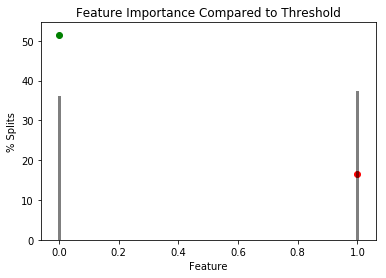

In [9]:
plot_feature_proportions_against_thresholds(proportions, thresholds)

In [10]:
final_features = kept_features(proportions, thresholds)
final_features

[0]